# Bird Clef 2023 - Kaggle Competition

### Members 

- Crevoiserat David
- El boudiri Anasse

### Import

In [1]:
# basic packages
import os
import json
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Deep Learning framework
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Audio processing
import torchaudio
import torchaudio.transforms as T
import IPython.display as ipd

# Image processing
from PIL import Image
import torchvision.transforms as transforms

# Pre-trained image models
import timm

/home/anasse/.local/share/virtualenvs/birdclef_2023-vuf4JCRr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

In [2]:
DATA_PATH = os.path.join('..', 'data', 'birdclef-2023')
TRAIN_PATH = os.path.join(DATA_PATH, 'train_audio_split')

In [3]:
X = []
y = []

for dirname, _, filename in os.walk(TRAIN_PATH):
    for file in filename:
        X.append(os.path.join(dirname, file))
        y.append(os.path.join(dirname, file).replace(TRAIN_PATH + os.sep, '').split(os.sep)[0])

# create pandas dataframe
df = pd.DataFrame({'file_path': X, 'label': y})
df

,file_path,label
0,../data/birdclef-2023/train_audio_split/trobou...,trobou1
1,../data/birdclef-2023/train_audio_split/trobou...,trobou1
2,../data/birdclef-2023/train_audio_split/trobou...,trobou1
3,../data/birdclef-2023/train_audio_split/trobou...,trobou1
4,../data/birdclef-2023/train_audio_split/trobou...,trobou1
...,...,...
130309,../data/birdclef-2023/train_audio_split/blhher...,blhher1
130310,../data/birdclef-2023/train_audio_split/blhher...,blhher1
130311,../data/birdclef-2023/train_audio_split/blhher...,blhher1
130312,../data/birdclef-2023/train_audio_split/blhher...,blhher1


### Data Exploration

- Example of a bird song

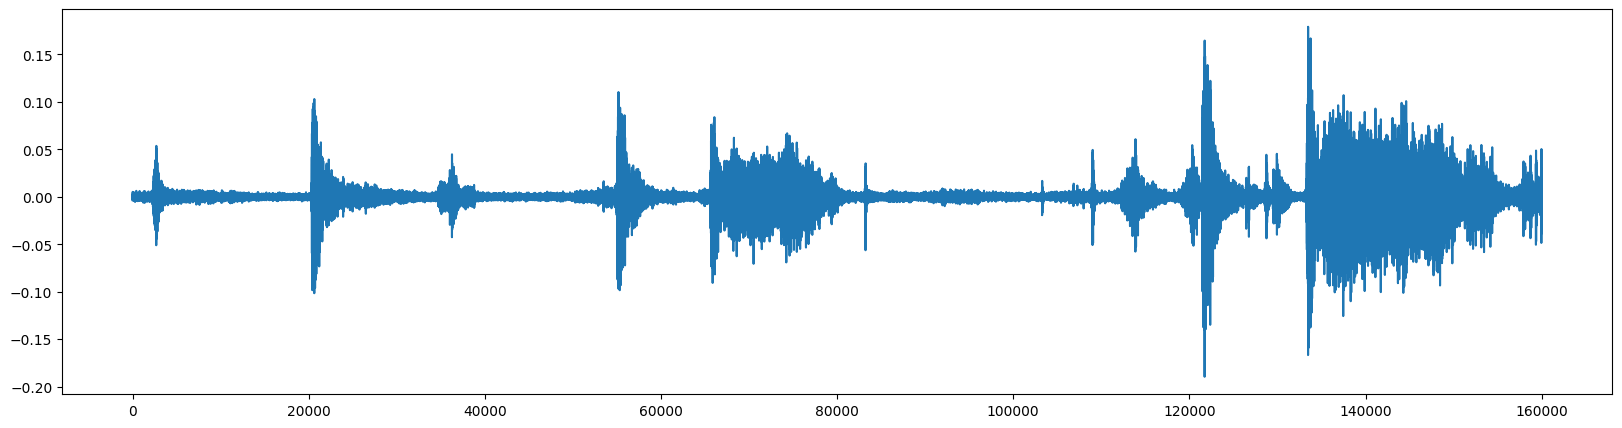

In [4]:
audio, sr = torchaudio.load(df['file_path'][3])
audio = audio
plt.figure(figsize=(20, 5))
plt.plot(audio.numpy()[0])
plt.show()

In [5]:
ipd.Audio(audio.numpy()[0], rate=32000)

- Distribution

In [6]:
groupby_label = df.groupby('label').count().reset_index().sort_values(by='file_path', ascending=False)
# plot with plotly
fig = px.bar(groupby_label, x='label', y='file_path', title='Number of audio files per label')
fig.show()

We observe that the distribution of the data is not balanced. We need to take this into account and try to fix it.

In [7]:
def remove_overrepresented_label(df, label, size=0.5):
    df_label = df.loc[df["label"] == label]
    half_size = int(len(df_label) * size)
    df_label_sampled = df_label.sample(n=half_size)
    return df.drop(df_label_sampled.index)

In [8]:
def augment_underrepresented_label(df, label, size=2):
    df_label = df[df["label"] == label]
    num_samples = int(size * len(df_label) - len(df_label))
    df_oversampled = df_label.sample(n=num_samples, replace=True)
    df_augmented = pd.concat([df, df_oversampled], ignore_index=True)
    return df_augmented

In [9]:
print(f'Number of rows before removal : {len(df)}')
label_to_remove = groupby_label[groupby_label['file_path'] > 10000]['label'].values

for label in label_to_remove:
    df = remove_overrepresented_label(df, label)

print(f'Number of rows after removal : {len(df)}')

Number of rows before removal : 130314
Number of rows after removal : 124272


In [10]:
print(f'Number of rows before augment : {len(df)}')
label_to_augment = groupby_label[groupby_label['file_path'] < 25]['label'].values

for label in label_to_augment:
    df = augment_underrepresented_label(df, label, size=4)

label_to_augment = groupby_label[groupby_label['file_path'] < 50]['label'].values

for label in label_to_augment:
    df = augment_underrepresented_label(df, label, size=2)

label_to_augment = groupby_label[groupby_label['file_path'] < 75]['label'].values

for label in label_to_augment:
    df = augment_underrepresented_label(df, label, size=1.5)

print(f'Number of rows after augment : {len(df)}')

Number of rows before augment : 124272
Number of rows after augment : 128800


In [11]:
groupby_label = df.groupby('label').count().reset_index().sort_values(by='file_path', ascending=False)
# plot with plotly
fig = px.bar(groupby_label, x='label', y='file_path', title='Number of audio files per label after update')
fig.show()

### One hot encoding

Create a one hot encoding for the labels and save it in a json file for later use in the prediction

In [12]:
# get unique label sorted by name
unique_labels = sorted(df['label'].unique())

# create dictionary with label as key and encoded label as value
label_to_id = {label: i for i, label in enumerate(unique_labels)}

for k in label_to_id.keys():
    label_to_id[k] = torch.nn.functional.one_hot(torch.tensor(label_to_id[k]), num_classes=len(unique_labels)).tolist()

# save one hot encoded labels in a json file
with open('one_hot_encoding.json', 'w') as f:
    json.dump(label_to_id, f)

In [13]:
# load one hot encoded labels from json file and add it to dataframe
with open('one_hot_encoding.json', 'r') as f:
    label_to_id = json.load(f)

df['encoded_label'] = df['label'].map(label_to_id)
df.head()

,file_path,label,encoded_label
0,../data/birdclef-2023/train_audio_split/trobou...,trobou1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,../data/birdclef-2023/train_audio_split/trobou...,trobou1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,../data/birdclef-2023/train_audio_split/trobou...,trobou1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,../data/birdclef-2023/train_audio_split/trobou...,trobou1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,../data/birdclef-2023/train_audio_split/trobou...,trobou1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


- mel spectrogram

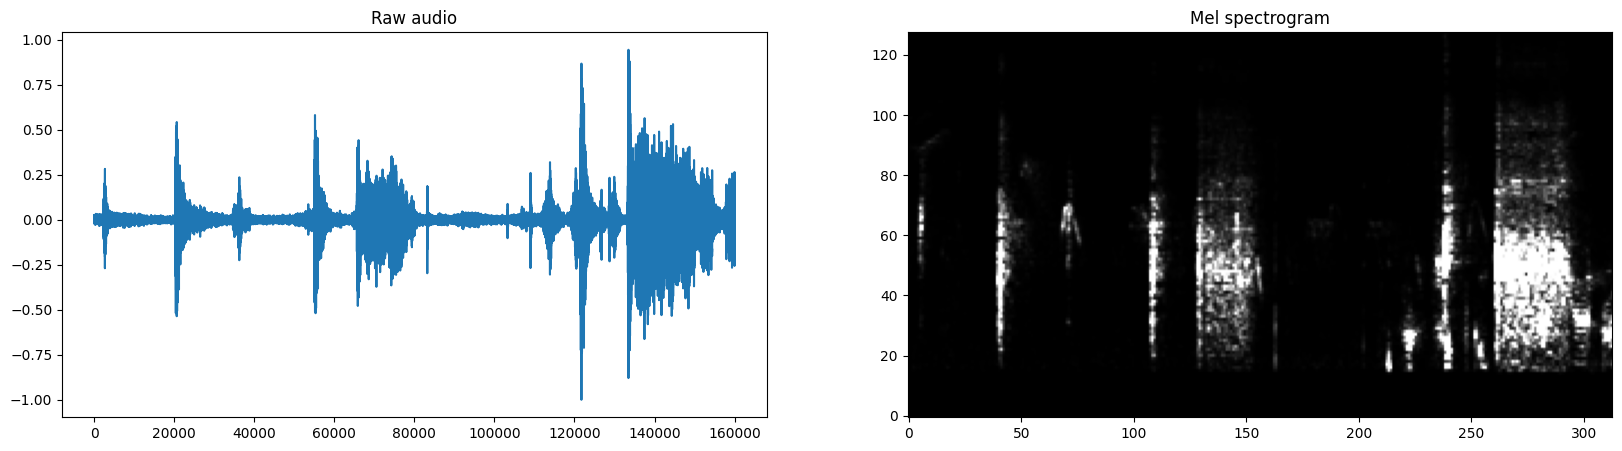

In [14]:
# mel spectrogram
audio = torch.mean(audio, axis=0)
audio = audio / torch.max(torch.abs(audio))


melspectrogram = T.MelSpectrogram(sample_rate=32000, n_mels=128, n_fft=2048, hop_length=512, f_min=500, f_max=15000)
melspec = melspectrogram(audio)

image = Image.fromarray(melspec.numpy())

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(audio)
plt.title('Raw audio')

plt.subplot(1, 2, 2)
plt.imshow(image, origin='lower', aspect='auto')
plt.title('Mel spectrogram')
plt.show()

So we will use the mel spectrogram to train our model with CNN.

### Dataset

In [15]:
class BirdDataset(Dataset):
    def __init__(self, df, sample_rate=32000):
        self.df = df
        self.file_paths = df['file_path'].values
        self.target = df['label'].values
        self.labels = df['encoded_label'].values
        self.sample_rate = sample_rate
        self.melspectrogram = T.MelSpectrogram(sample_rate=self.sample_rate, n_mels=128, n_fft=2048, hop_length=512, f_min=500, f_max=15000)
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        audio, sr = torchaudio.load(self.file_paths[idx])

        # if audio has more than one channel, convert it to mono by averaging the channels
        audio = torch.mean(audio, axis=0)

        if sr != self.sample_rate:
            resampler = T.Resample(sr, self.sample_rate)
            audio = resampler(audio)

        # add random noise to audio
        if np.random.rand() < 0.3:
            noise = torch.randn_like(audio) * 0.005
            audio += noise

        # normalize audio 
        audio = audio / torch.max(torch.abs(audio))

        # convert audio to melspectrogram
        melspec = self.melspectrogram(audio)

        # convert melspec to image
        image = Image.fromarray(melspec.numpy())
        image = image.convert("RGB")

        return {"image": self.preprocess(image), "label": torch.Tensor(self.labels[idx]), "label_text": self.target[idx]}

### Split data into train and val

In [16]:
from sklearn.model_selection import train_test_split

# stratify split on label to have same distribution of labels in train and val set
train_df, val_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['label'], shuffle=True)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df.shape, val_df.shape

((109480, 3), (19320, 3))

In [17]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [18]:
train_dataset = BirdDataset(train_df)
val_dataset = BirdDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

### Model

In [19]:
class BirdModel(nn.Module):
    def __init__(self, model_name='tf_efficientnet_b3', pretrained=True, num_classes=264):
        super(BirdModel, self).__init__()

        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(self.in_features, num_classes)
        )
   

    def forward(self, img):
        return self.model(img)

In [20]:
model = BirdModel()
model.to(device)

BirdModel(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNormAct2d(
            40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(

### Training

training is done on `train_model.py` because of the training time.

In [21]:
from tqdm.auto import tqdm

EPOCHS = 10
BEST_MODEL_PATH = os.path.join("..", "model", "best_bird_model.pth")

# parameters
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                              T_max = 100,
                              eta_min = 1e-5) 
criterion = nn.CrossEntropyLoss()

# history
train_loss_history, val_loss_history = [], []
train_accuracy_history, val_accuracy_history = [], []
best_accuracy = 0.0

# train
model.train()

for _ in tqdm(range(EPOCHS+1), total=EPOCHS, desc='Epochs'):
    train_loss = 0.0
    train_error_count = 0.0
    
    for data in train_loader:
        optimizer.zero_grad()
        X = data['image'].to(device)
        y = data['label'].to(device)

        outputs = model(X)

        loss = criterion(outputs, y)
        train_loss += loss.item()
        train_error_count += (outputs.argmax(1) != y.argmax(1)).sum().item()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_loader)
    val_loss = 0.0
    val_error_count = 0.0

    for data in val_loader:
        X = data['image'].to(device)
        y = data['label'].to(device)

        outputs = model(X)
    
        loss = criterion(outputs, y)
        val_loss += loss.item()
        val_error_count += (outputs.argmax(1) != y.argmax(1)).sum().item()

    val_loss /= len(val_loader)

    train_accuracy = 1.0 - float(train_error_count) / len(train_dataset)
    val_accuracy = 1.0 - float(val_error_count) / len(val_dataset)

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

    # save best model
    if val_accuracy > best_accuracy:
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        best_accuracy = val_accuracy

### Results

made in `train_model.py`

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.plot(train_loss_history, label='train')
ax1.plot(val_loss_history, label='val')
ax1.set_title('Loss history')
ax1.legend()

ax2.plot(train_accuracy_history, label='train')
ax2.plot(val_accuracy_history, label='val')
ax2.set_title('Accuracy history')
ax2.legend()
plt.savefig(os.path.join('assets','history.png'))
plt.show()

![loss](./assets/history.png)

### Metrics final model

made in `train_model.py`

In [23]:
model = BirdModel(pretrained=False)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.to(device)
model.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for data in val_loader:

        X = data["image"].to(device)
        y = data["label"]

        outputs = model(X)

        y_true.extend(torch.argmax(outputs, dim=1).detach().cpu().numpy())
        y_pred.extend(torch.argmax(y, dim=1).numpy())

In [27]:
with open(os.path.join('assets',"metrics.txt"), 'r') as f:
    metrics = f.read()
    print(metrics)

Accuracy: 0.7669772256728778
F1: 0.7621182691124213
Precision: 0.741745115135625
Recall: 0.8024357114989734

